In [68]:
import glob
import pandas as pd
import json

projects = ["djanjo", "flask", "pytorch", "pandas"]
dfs=[]

for project in projects:
    filenames = glob.glob(f"../output/pytlint/{project}/*.json")
    for filename in filenames:
        with open(filename) as json_data:
            data = json.load(json_data)
            df = pd.json_normalize(data)
            df['project'] = project
            dfs.append(df)




In [69]:
df_py = pd.concat(dfs, ignore_index=True)

df_py.head(5)

,type,module,obj,line,column,endLine,endColumn,path,symbol,message,message-id,project
0,warning,flask.cli,FlaskGroup.list_commands,605,15,605,24,projects/py/flask/src/flask/cli.py,broad-except,Catching too general exception Exception,W0703,flask
1,warning,flask.cli,run_command,898,11,898,20,projects/py/flask/src/flask/cli.py,broad-except,Catching too general exception Exception,W0703,flask
2,warning,test_reqctx,test_teardown_with_previous_exception,39,11,39,20,projects/py/flask/tests/test_reqctx.py,broad-except,Catching too general exception Exception,W0703,flask
3,warning,test_reqctx,test_teardown_with_handled_exception,58,15,58,24,projects/py/flask/tests/test_reqctx.py,broad-except,Catching too general exception Exception,W0703,flask
4,warning,test_appctx,test_app_tearing_down_with_previous_exception,66,11,66,20,projects/py/flask/tests/test_appctx.py,broad-except,Catching too general exception Exception,W0703,flask


In [70]:
df_py.groupby(['project','message-id'])['message-id'].count()

project  message-id
flask    W0703           9
pandas   W0703          24
         W0706           2
         W0707          23
pytorch  E0702           5
         E0704           2
         W0702           4
         W0703         253
         W0706           6
         W0707           9
         W0715          11
Name: message-id, dtype: int64

In [71]:
import psycopg2

conn = psycopg2.connect("host={} user={} dbname=exception_miner password={} port={}".format("127.0.0.1", "exception_miner", "exception_miner", "5432"))
conn.set_session(autocommit=True)
cur = conn.cursor()

cur.execute("""CREATE TABLE IF NOT EXISTS exceptions_pylint (type VARCHAR(255), module VARCHAR(255), obj VARCHAR(255), beginLine INT, beginColumn INT,	endLine INT, endColumn INT, path VARCHAR(255), symbol VARCHAR(255), message VARCHAR(255), message_id VARCHAR(255), project VARCHAR(255))""")

cur.execute("""DELETE FROM exceptions_pylint;""")

for i, row in df_py.iterrows():
    #print(row)
    cur.execute(("""INSERT INTO exceptions_pylint (type, module, obj, beginLine, beginColumn, endLine, endColumn, path, symbol, message, message_id, project)
                            VALUES (%s, %s, %s, %s, %s, %s,%s, %s, %s, %s, %s, %s  );"""), list(row))

OperationalError: connection to server at "127.0.0.1", port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?


Python Parser

In [72]:
import glob
import pandas as pd
import json

# projects = ["django", "flask", "pytorch", "pandas"]
projects = ["flask"]
dfs=[]

for project in projects:
    #filenames = glob.glob(f"../output/parser/*.csv")
    #print(filename)
    df = pd.read_csv(f"../output/parser/{project}_stats.csv")
    df['project'] = project
    dfs.append(df)


In [73]:
df = pd.concat(dfs, ignore_index=True)
df.head(5)

,file,function,func_body,str_uncaught_exceptions,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,...,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,n_nested_try,n_bare_except,n_bare_raise_finally,project
0,/home/r4ph/desenv/exception-miner/projects/py/...,test_add,"def test_add(client, a, b, result):\n respo...",NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,flask
1,/home/r4ph/desenv/exception-miner/projects/py/...,check,"def check(sender, template, context):\n ...",NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,flask
2,/home/r4ph/desenv/exception-miner/projects/py/...,test_index,"def test_index(app, client, path, template_nam...",NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,flask
3,/home/r4ph/desenv/exception-miner/projects/py/...,client,def client(app):\n return app.test_client(),NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,flask
4,/home/r4ph/desenv/exception-miner/projects/py/...,fixture_app,def fixture_app():\n app.testing = True\n ...,NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,flask


In [74]:
df[df['str_uncaught_exceptions'].isnull() == False].shape

(5, 21)

In [75]:
df[df['n_bare_except'] > 0]

,file,function,func_body,str_uncaught_exceptions,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,...,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,n_nested_try,n_bare_except,n_bare_raise_finally,project


In [76]:
df.shape

(1412, 21)

In [77]:
#TODO:
#Analisar Duplicados
df[df.duplicated()]

,file,function,func_body,str_uncaught_exceptions,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,...,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,n_nested_try,n_bare_except,n_bare_raise_finally,project
157,/home/r4ph/desenv/exception-miner/projects/py/...,hello_command,"def hello_command():\n click.echo(""Hell...",NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,flask
162,/home/r4ph/desenv/exception-miner/projects/py/...,view,def view(company_id):\n return company_id,NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,flask
187,/home/r4ph/desenv/exception-miner/projects/py/...,index,def index():\n return flask.request.url,NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,flask
193,/home/r4ph/desenv/exception-miner/projects/py/...,index,def index():\n flask.g.user_agent = fla...,NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,flask
195,/home/r4ph/desenv/exception-miner/projects/py/...,index,def index():\n return flask.request.url,NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,flask
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,/home/r4ph/desenv/exception-miner/projects/py/...,index,"def index():\n return f""Hello {flask.re...",NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,flask
1015,/home/r4ph/desenv/exception-miner/projects/py/...,end_of_request,def end_of_request(exception):\n buffer...,NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,flask
1017,/home/r4ph/desenv/exception-miner/projects/py/...,end_of_request,def end_of_request(exception):\n buffer...,NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,flask
1088,/home/r4ph/desenv/exception-miner/projects/py/...,to_json,"def to_json(self, value: t.Any) -> t.Any:\n ...",NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,flask


Analyzing the Control Flow and Code

In [78]:
import glob
import pandas as pd
import json

projects = ["django", "flask", "pytorch", "pandas"]
dfs=[]
filenames = glob.glob(f"../output/parser/*.csv")

for filename in filenames:
    #filenames = glob.glob(f"../output/parser/*.csv")
    #print(filename)
    df = pd.read_csv(filename)
    project = filename.split("/")[-1].split("_")[0]
    df['project'] = project
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [79]:
df.shape

(207934, 21)

In [80]:
df.drop_duplicates()

,file,function,func_body,str_uncaught_exceptions,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,...,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,n_nested_try,n_bare_except,n_bare_raise_finally,project
0,/home/r4ph/desenv/exception-miner/projects/py/...,main,def main(_):\n tf.logging.set_verbosity(tf.lo...,...run_classifier_with_tfhub.model_fn_builder:...,0,0,0,0,3,0,...,0,0,0,NaN,ValueError ValueError ValueError,NaN,0,0,0,bert
1,/home/r4ph/desenv/exception-miner/projects/py/...,convert_examples_to_features,"def convert_examples_to_features(examples, lab...",NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,bert
2,/home/r4ph/desenv/exception-miner/projects/py/...,input_fn,"def input_fn(params):\n """"""The actual input...",NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,bert
3,/home/r4ph/desenv/exception-miner/projects/py/...,input_fn_builder,"def input_fn_builder(features, seq_length, is_...",NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,bert
4,/home/r4ph/desenv/exception-miner/projects/py/...,metric_fn,"def metric_fn(per_example_loss, label_ids, log...",NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,bert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207929,/home/r4ph/desenv/exception-miner/projects/py/...,check_md_file,def check_md_file(file_name):\n with open(p...,NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,devops-exercises
207930,/home/r4ph/desenv/exception-miner/projects/py/...,check_summary_tag,"def check_summary_tag(file_list):\n """"""\n ...",NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,devops-exercises
207931,/home/r4ph/desenv/exception-miner/projects/py/...,check_details_tag,"def check_details_tag(file_list):\n """"""\n ...",NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,devops-exercises
207932,/home/r4ph/desenv/exception-miner/projects/py/...,count_summary,"def count_summary(file_list):\n """"""\n Co...",NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,devops-exercises


In [81]:
df.project.unique()

array(['bert', 'python-100-days', 'fastapi', 'rich', 'faceswap',
       'ailearning', 'sherlock', 'youtube-dl', 'cheat.sh',
       'real-time-voice-cloning', 'face', 'system-design-primer',
       'you-get', 'ansible', 'payloadsallthethings', 'django', 'thefuck',
       'mitmproxy', 'scrapy', 'scikit-learn', 'public-apis', 'certbot',
       'localstack', 'd2l-zh', 'python-cheatsheet', 'cppcoreguidelines',
       'keras', 'transformers', 'models', 'wtfpython', 'sentry',
       'awesome-python', 'hellogithub', 'big-list-of-naughty-strings',
       'xx-net', '12306', 'deep-learning-papers-reading-roadmap', 'gym',
       'python-patterns', 'requests', 'flask', 'manim', 'deepfacelab',
       'black', 'hackingtool', 'openpilot', 'devops-exercises'],
      dtype=object)

In [82]:
len(df.project.unique())

47

In [83]:
df.shape

(207934, 21)

In [84]:
df.head(5)

,file,function,func_body,str_uncaught_exceptions,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,...,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,n_nested_try,n_bare_except,n_bare_raise_finally,project
0,/home/r4ph/desenv/exception-miner/projects/py/...,main,def main(_):\n tf.logging.set_verbosity(tf.lo...,...run_classifier_with_tfhub.model_fn_builder:...,0,0,0,0,3,0,...,0,0,0,NaN,ValueError ValueError ValueError,NaN,0,0,0,bert
1,/home/r4ph/desenv/exception-miner/projects/py/...,convert_examples_to_features,"def convert_examples_to_features(examples, lab...",NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,bert
2,/home/r4ph/desenv/exception-miner/projects/py/...,input_fn,"def input_fn(params):\n """"""The actual input...",NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,bert
3,/home/r4ph/desenv/exception-miner/projects/py/...,input_fn_builder,"def input_fn_builder(features, seq_length, is_...",NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,bert
4,/home/r4ph/desenv/exception-miner/projects/py/...,metric_fn,"def metric_fn(per_example_loss, label_ids, log...",NaN,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0,0,0,bert


In [85]:
df[df['str_except_identifiers'].notna()].head(10)

,file,function,func_body,str_uncaught_exceptions,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,...,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,n_nested_try,n_bare_except,n_bare_raise_finally,project
220,/home/r4ph/desenv/exception-miner/projects/py/...,main,def main():\n os.environ.setdefault('DJANGO...,NaN,1,0,0,0,1,0,...,0,0,0,ImportError,ImportError,"raise ImportError(\n ""Couldn't impo...",0,0,0,python-100-days
232,/home/r4ph/desenv/exception-miner/projects/py/...,fib,"def fib(num, results={}):\n """"""斐波拉切数""""""\n ...",NaN,1,0,0,0,0,0,...,0,0,1,KeyError,NaN,results[num] = fib(num - 1) + fib(num - 2)\n ...,0,0,0,python-100-days
577,/home/r4ph/desenv/exception-miner/projects/py/...,run,def run(self):\n try:\n ...,NaN,2,0,0,2,0,0,...,0,0,0,Exception Exception,NaN,print(e)\n clients.remo...,0,0,0,python-100-days
579,/home/r4ph/desenv/exception-miner/projects/py/...,main,def main():\n\n class ClientHandler(Thread)...,NaN,2,0,0,2,0,0,...,0,0,0,Exception Exception,NaN,print(e)\n clients.remo...,0,0,0,python-100-days
593,/home/r4ph/desenv/exception-miner/projects/py/...,main,def main():\n # 通过sys.argv获取命令行参数\n if l...,NaN,1,0,0,0,0,0,...,0,0,0,FileNotFoundError,NaN,print('不能执行%s命令' % sys.argv[index]),0,0,0,python-100-days
646,/home/r4ph/desenv/exception-miner/projects/py/...,find_contacters_by_name,def find_contacters_by_name(con):\n name = ...,NaN,1,0,0,0,0,0,...,0,0,0,pymysql MySQLError,NaN,print(err),0,0,0,python-100-days
647,/home/r4ph/desenv/exception-miner/projects/py/...,find_all_contacters,"def find_all_contacters(con):\n page, size ...",NaN,1,0,0,0,0,0,...,0,0,0,pymysql MySQLError,NaN,print(err),0,0,0,python-100-days
650,/home/r4ph/desenv/exception-miner/projects/py/...,edit_contacter_info,"def edit_contacter_info(con, contacter):\n ...",NaN,1,0,0,0,0,0,...,0,0,0,pymysql MySQLError,NaN,print(err)\n print('更新联系人信息失败!'),0,0,0,python-100-days
651,/home/r4ph/desenv/exception-miner/projects/py/...,delete_contacter,"def delete_contacter(con, contacter):\n try...",NaN,1,0,0,0,0,0,...,0,0,0,pymysql MySQLError,NaN,print(err)\n print('删除联系人失败!'),0,0,0,python-100-days
652,/home/r4ph/desenv/exception-miner/projects/py/...,add_new_contacter,"def add_new_contacter(con):\n name, tel, em...",NaN,1,0,0,0,0,0,...,0,0,0,pymysql MySQLError,NaN,print(err)\n print('添加联系人失败!'),0,0,0,python-100-days


In [86]:
df.iloc[428,:].func_body

"def reverse_str5(str):\n    # 将字符串处理成列表\n    str_list = list(str)\n    str_len = len(str)\n    # 使用zip函数将两个序列合并成一个产生元组的迭代器\n    # 每次正好可以取到一前一后两个下标来实现元素的交换\n    for i, j in zip(range(str_len // 2), range(str_len - 1, str_len // 2, -1)):\n        str_list[i], str_list[j] = str_list[j], str_list[i]\n    # 将列表元素连接成字符串\n    return ''.join(str_list)"

In [87]:
df.iloc[428,:].str_except_identifiers

nan

In [88]:
df[df['n_bare_raise_finally'] > 1]#.count()

,file,function,func_body,str_uncaught_exceptions,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,...,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,n_nested_try,n_bare_except,n_bare_raise_finally,project


In [89]:
df.iloc[500, :].func_body

'def accelerate(self, delta):\n        self._current_speed += delta\n        if self._current_speed > self._max_speed:\n            self._current_speed = self._max_speed'

In [90]:
# from pandasql import sqldf

# q = """SELECT asd.project,
#        asd.n_functions,
#        asd.n_try_except,
#        ROUND((CAST(asd.n_try_except AS FLOAT) / CAST(asd.n_functions AS FLOAT)), 4) * 100                 as perc_trys_func,
#        asd.n_try_return,
#        ROUND((CAST(asd.n_try_return AS FLOAT) / CAST (asd.n_functions AS FLOAT)), 4) * 100  as perc_n_try_return,
#        asd.n_generic_except,
#        ROUND((CAST(asd.n_generic_except AS FLOAT) / CAST(asd.n_try_except AS FLOAT)), 4) * 100            as perc_try_generic,
#        asd.n_try_pass,
#        ROUND((CAST(asd.n_try_pass AS FLOAT) / CAST(asd.n_try_except AS FLOAT)), 4) * 100                  as perc_try_pass,
#        asd.n_try_else,
#        ROUND((CAST(asd.n_try_else AS FLOAT) / CAST (asd.n_try_except AS FLOAT)), 4) * 100  as perc_n_try_else,
#        asd.n_raise,
#        ROUND((CAST(asd.n_raise AS FLOAT) / CAST(asd.n_functions AS FLOAT)), 4) * 100 as perc_raise,
#        asd.n_captures_try_except_raise,
#        ROUND((CAST(asd.n_captures_try_except_raise AS FLOAT) / CAST(asd.n_raise AS FLOAT)), 4) * 100 as perc_try_except_raise,
#        asd.n_captures_broad_raise,
#        ROUND((CAST(asd.n_captures_broad_raise AS FLOAT) / CAST(asd.n_raise AS FLOAT)), 4) * 100      as perc_raise_broad,
#        asd.n_captures_misplaced_bare_raise,
#        ROUND((CAST(asd.n_captures_misplaced_bare_raise AS FLOAT) / CAST (asd.n_raise AS FLOAT)), 4) * 100  as perc_raise_mis_bare,
#        asd.n_finally,
#        ROUND((CAST(asd.n_finally AS FLOAT) / CAST (asd.n_try_except AS FLOAT)), 4) * 100  as perc_finally
# FROM (SELECT a.project,
#              COUNT(DISTINCT a.function)                n_functions,
#              SUM(a.n_try_except)                    as n_try_except,
#              SUM(a.n_generic_except)                as n_generic_except,
#              SUM(a.n_try_pass)                      as n_try_pass,
#              SUM(a.n_raise)                         as n_raise,
#              SUM(a.n_captures_try_except_raise)     as n_captures_try_except_raise,
#              SUM(a.n_captures_misplaced_bare_raise) as n_captures_misplaced_bare_raise,
#              SUM(a.n_captures_broad_raise)          as n_captures_broad_raise,
#              SUM(a.n_try_else)                      as n_try_else,
#              SUM(a.n_try_return)                    as n_try_return,
#              SUM(a.n_finally)                       as n_finally
#       FROM df a
#       GROUP BY a.project) asd;"""
# sqldf(q)



In [91]:
df[df['n_try_except'] >1]

,file,function,func_body,str_uncaught_exceptions,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,...,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,n_nested_try,n_bare_except,n_bare_raise_finally,project
577,/home/r4ph/desenv/exception-miner/projects/py/...,run,def run(self):\n try:\n ...,NaN,2,0,0,2,0,0,...,0,0,0,Exception Exception,NaN,print(e)\n clients.remo...,0,0,0,python-100-days
579,/home/r4ph/desenv/exception-miner/projects/py/...,main,def main():\n\n class ClientHandler(Thread)...,NaN,2,0,0,2,0,0,...,0,0,0,Exception Exception,NaN,print(e)\n clients.remo...,0,0,0,python-100-days
1675,/home/r4ph/desenv/exception-miner/projects/py/...,create_item,async def create_item(request: Request):\n ...,NaN,2,0,0,0,2,0,...,0,0,0,yaml YAMLError ValidationError,HTTPException HTTPException,"raise HTTPException(status_code=422, detail=""I...",0,0,0,fastapi
1788,/home/r4ph/desenv/exception-miner/projects/py/...,check_file_field,def check_file_field(field: ModelField) -> Non...,NaN,2,0,0,0,2,0,...,0,0,0,ImportError ImportError,RuntimeError RuntimeError,logger.error(multipart_incorrect_install_error...,0,0,0,fastapi
1869,/home/r4ph/desenv/exception-miner/projects/py/...,app,async def app(request: Request) -> Response:\n...,NaN,3,0,0,1,4,0,...,0,0,0,json JSONDecodeError HTTPException Exception,RequestValidationError HTTPException RequestVa...,raise RequestValidationError(\n ...,0,0,0,fastapi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207194,/home/r4ph/desenv/exception-miner/projects/py/...,reconnect,def reconnect(self):\n if self._handle_open...,NaN,2,2,0,2,1,1,...,0,0,0,Exception Exception Exception,Exception,"logging.debug(""reconnecting is taking %d secon...",0,0,0,openpilot
207198,/home/r4ph/desenv/exception-miner/projects/py/...,usb_list,def usb_list():\n ret = []\n try:\n ...,NaN,2,0,0,2,0,0,...,0,0,0,Exception Exception,NaN,"continue logging.exception(""exception while li...",0,0,0,openpilot
207200,/home/r4ph/desenv/exception-miner/projects/py/...,usb_connect,"def usb_connect(serial, claim=True, wait=False...",NaN,2,0,0,2,0,0,...,0,0,0,Exception Exception,NaN,"continue logging.exception(""USB connect error"")",0,0,0,openpilot
207238,/home/r4ph/desenv/exception-miner/projects/py/...,usb_list,def usb_list() -> List[str]:\n dfu_serials ...,NaN,2,2,0,2,0,0,...,0,0,0,Exception Exception,NaN,pass pass,0,0,0,openpilot


In [92]:
df.str_except_block

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
207929    NaN
207930    NaN
207931    NaN
207932    NaN
207933    NaN
Name: str_except_block, Length: 207934, dtype: object

In [93]:
df.str_except_block.str.split(" ").explode().value_counts().reset_index().head(50)
#df_except_types = df.str_except_identifiers.str.split(" ").explode().value_counts().reset_index()
#df_raise_types = df_raise_types[1:]
#df_raise_types.head(20)

,index,str_except_block
0,,283097
1,=,3890
2,raise,3843
3,return,2429
4,if,1840
5,to,1795
6,pass,1358
7,%,1319
8,not,1301
9,in,1104


In [94]:
df.str_except_identifiers.unique()

array([nan, 'ImportError', 'KeyError', ...,
       'usb1 USBErrorIO usb1 USBErrorOverflow',
       'BaseException BaseException', 'usb1 USBErrorTimeout'],
      dtype=object)

RQ1. How common and what are the main characteristics of exception handling practices in Python open-source projects?

In [95]:
cols = ['n_try_except', 'n_raise', 'n_finally', 'n_try_else']

for col in cols:
    df[col+'_uni'] = df[col].apply(lambda x: 1 if x >= 1 else x)

In [96]:
df_rq1 = df.agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_finally_uni': ['sum'], 'n_try_else_uni': ['sum'] })
df_rq1 = df_rq1.max().to_frame().T

#df_rq1 = df.groupby('project').agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_finally_uni': ['sum'], 'n_try_else_uni': ['sum'] }).reset_index()
#df_rq1.columns = list(map(''.join, df_rq1.columns.values))


In [97]:
cols = ['n_finally_uni', 'n_try_else_uni']

df_rq1['perc_n_try_except_uni'] = (df_rq1['n_try_except_uni']/ df_rq1['function']) * 100
df_rq1['perc_n_raise_uni'] = (df_rq1['n_raise_uni']/ df_rq1['function']) * 100

for col in cols:
     df_rq1['perc_'+col]= (df_rq1[col]/ df_rq1['n_try_except_uni']) * 100

df_rq1

,function,n_try_except_uni,n_raise_uni,n_finally_uni,n_try_else_uni,perc_n_try_except_uni,perc_n_raise_uni,perc_n_finally_uni,perc_n_try_else_uni
0,207928.0,8399.0,19073.0,1153.0,683.0,4.039379,9.172887,13.727825,8.13192


In [98]:
#df_rq1.loc[:, ["perc_n_try_except_unisum", "perc_n_raise_unisum", "perc_n_try_else_unisum", "perc_n_finally_unisum"]]

In [99]:
#df_total = df_rq1.agg({'perc_n_try_except_unisum': ['median', 'mean'], 'perc_n_raise_unisum': ['median', 'mean'], 'perc_n_try_else_unisum': ['median', 'mean'], 'perc_n_finally_unisum': ['median', 'mean']})
#df_total

In [100]:
df_total = df_rq1.loc[:, ["perc_n_try_except_uni", "perc_n_raise_uni", "perc_n_try_else_uni", "perc_n_finally_uni"]]

In [101]:
df_total.columns = ['try-except', 'raise', 'try-else', 'try-finally']
df_total

,try-except,raise,try-else,try-finally
0,4.039379,9.172887,8.13192,13.727825


In [102]:
df_total = df_total.T[0:].reset_index()
df_total

,index,0
0,try-except,4.039379
1,raise,9.172887
2,try-else,8.131920
3,try-finally,13.727825


In [103]:
#rename columns:
df_total.columns = ['Exception Handling', 'Percentage']
df_total['Percentage'] = df_total['Percentage'].round(2)


In [104]:
df_total = df_total.sort_values(by=['Percentage'], ascending=False)
df_total

,Exception Handling,Percentage
3,try-finally,13.73
1,raise,9.17
2,try-else,8.13
0,try-except,4.04


Boxplots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


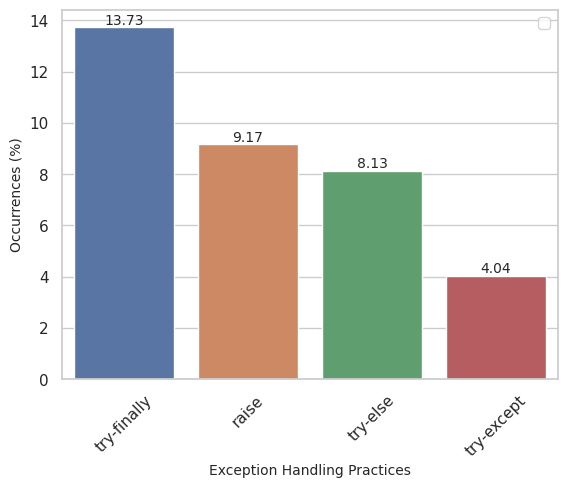

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_total, x="Exception Handling", y="Percentage")
plt.ylabel("Occurrences (%)", fontsize= 10)
plt.xlabel("Exception Handling Practices", fontsize= 10)
plt.tick_params(axis='x', rotation=45)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=10)



In [106]:
df_except_types = df.str_except_identifiers.str.split(" ").explode().value_counts().reset_index()

In [107]:
df_except_types

,index,str_except_identifiers
0,Exception,2534
1,ValueError,1207
2,KeyError,791
3,DoesNotExist,613
4,AttributeError,578
...,...,...
1101,DockerNotAvailable,1
1102,InvalidEnvVars,1
1103,OperationNotFoundParserError,1
1104,MissingRequiredField,1


In [108]:
#df_except_types = df_except_types[1:]

In [109]:
def get_capitalized_elements(list):
    for element in list:
        if element[0].isupper():
            return element

In [110]:
#TODO: get a list of built-in exceptions and flag them
df_except_types['str_uniq_identifiers'] = df_except_types['index'].apply(lambda x: get_capitalized_elements(x.split(".")))

df_except_types = df_except_types[df_except_types['str_uniq_identifiers'].notna()].head(20)

In [111]:
df_except_types = df_except_types.head(20) 
df_except_types['perc'] =  ((df_except_types['str_except_identifiers']/ df_except_types['str_except_identifiers'].sum()) * 100).round(2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


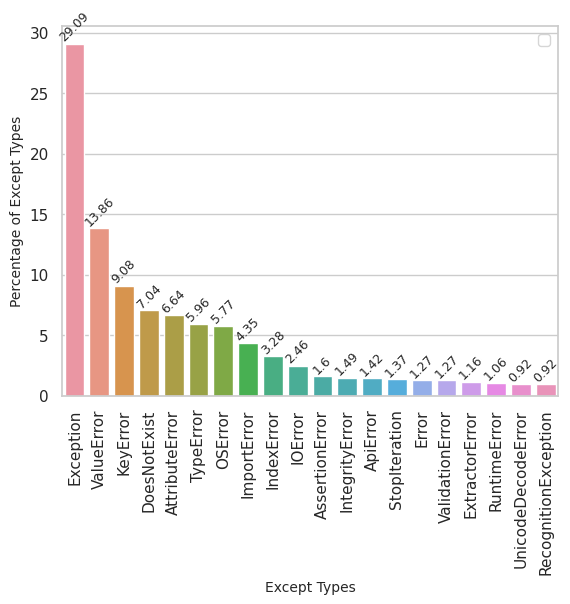

In [112]:
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_except_types, x="str_uniq_identifiers", y="perc")
plt.ylabel("Percentage of Except Types", fontsize= 10)
plt.xlabel("Except Types", fontsize= 10)
plt.tick_params(axis='x', rotation=90)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=9, rotation=45)


In [113]:
df_raise_types = df.str_raise_identifiers.str.split(" ").explode().value_counts().reset_index()
df_raise_types = df_raise_types[1:]
df_raise_types.head(20)

,index,str_raise_identifiers
1,NotImplementedError,4117
2,Exception,1113
3,TypeError,902
4,RuntimeError,523
5,AnsibleError,503
6,ExtractorError,490
7,AssertionError,299
8,ValidationError,294
9,e,227
10,AttributeError,210


In [114]:
df_raise_types['str_uniq_identifiers'] = df_raise_types['index'].apply(lambda x: get_capitalized_elements(x.split(".")))

df_raise_types = df_raise_types[df_raise_types['str_uniq_identifiers'].notna()].head(20)

In [115]:
df_raise_types = df_raise_types.head(20) 
df_raise_types['perc'] =  ((df_raise_types['str_raise_identifiers']/ df_raise_types['str_raise_identifiers'].sum()) * 100).round(2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


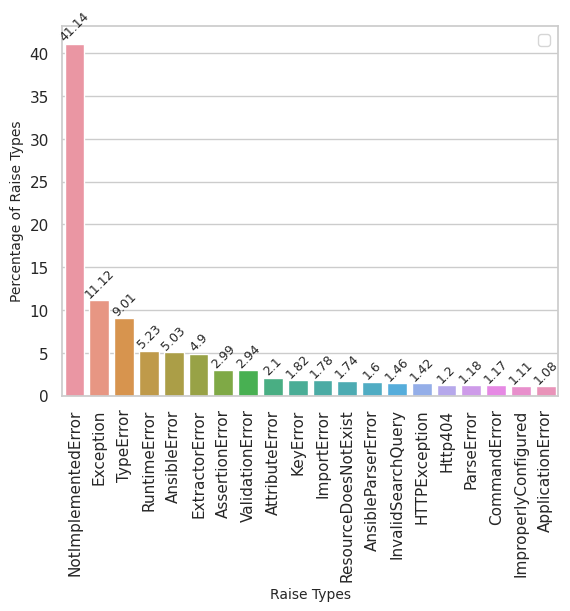

In [116]:
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_raise_types, x="index", y="perc")
plt.ylabel("Percentage of Raise Types", fontsize= 10)
plt.xlabel("Raise Types", fontsize= 10)
plt.tick_params(axis='x', rotation=90)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=9, rotation=45)

RQ2. 

In [117]:
df[df.str_uncaught_exceptions.notna()].str_uncaught_exceptions.values

#df.str_uncaught_exceptions.str.split("[.][.][.]").values

array(['...run_classifier_with_tfhub.model_fn_builder:ValueError ...extract_features.model_fn_builder:ValueError ...run_pretraining.model_fn_builder:ValueError ...run_squad.read_squad_examples:ValueError ...run_squad.model_fn_builder:ValueError ...run_squad.validate_flags_or_throw:ValueError ...run_squad.validate_flags_or_throw:ValueError ...run_squad.validate_flags_or_throw:ValueError ...run_squad.validate_flags_or_throw:ValueError ...run_squad.validate_flags_or_throw:ValueError',
       '...modeling.transformer_model:ValueError ...modeling.transformer_model:ValueError ...modeling.get_activation:ValueError ...modeling.embedding_postprocessor:ValueError',
       '...tokenization.convert_to_unicode:ValueError ...tokenization.convert_to_unicode:ValueError ...tokenization.convert_to_unicode:ValueError ...tokenization.convert_to_unicode:ValueError ...tokenization.convert_to_unicode:ValueError ...tokenization.convert_to_unicode:ValueError',
       ..., '...tools.latencylogger.latency_logger

In [118]:
import numpy as np
#Couting uncaught exceptions:
#df[df.str_uncaught_exceptions.notna()].str_uncaught_exceptions.str.split("[.][.][.]").values[3]

df['n_uncaught_exceptions'] = df['str_uncaught_exceptions'].str.split("[.][.][.]").apply(lambda x: len(x)-1 if x is not np.nan else 0)

In [119]:
df.columns

Index(['file', 'function', 'func_body', 'str_uncaught_exceptions',
       'n_try_except', 'n_try_pass', 'n_finally', 'n_generic_except',
       'n_raise', 'n_captures_broad_raise', 'n_captures_try_except_raise',
       'n_captures_misplaced_bare_raise', 'n_try_else', 'n_try_return',
       'str_except_identifiers', 'str_raise_identifiers', 'str_except_block',
       'n_nested_try', 'n_bare_except', 'n_bare_raise_finally', 'project',
       'n_try_except_uni', 'n_raise_uni', 'n_finally_uni', 'n_try_else_uni',
       'n_uncaught_exceptions'],
      dtype='object')

In [120]:
cols = ['n_captures_misplaced_bare_raise', 'n_generic_except', 'n_captures_broad_raise', 'n_try_pass', 'n_try_return', 'n_nested_try', 'n_uncaught_exceptions', 'n_try_except', 
        'n_raise', 'n_bare_raise_finally', 'n_bare_except']

for col in cols:
    df[col+'_uni'] = df[col].apply(lambda x: 1 if x >= 1 else x)

In [121]:
df.columns

Index(['file', 'function', 'func_body', 'str_uncaught_exceptions',
       'n_try_except', 'n_try_pass', 'n_finally', 'n_generic_except',
       'n_raise', 'n_captures_broad_raise', 'n_captures_try_except_raise',
       'n_captures_misplaced_bare_raise', 'n_try_else', 'n_try_return',
       'str_except_identifiers', 'str_raise_identifiers', 'str_except_block',
       'n_nested_try', 'n_bare_except', 'n_bare_raise_finally', 'project',
       'n_try_except_uni', 'n_raise_uni', 'n_finally_uni', 'n_try_else_uni',
       'n_uncaught_exceptions', 'n_captures_misplaced_bare_raise_uni',
       'n_generic_except_uni', 'n_captures_broad_raise_uni', 'n_try_pass_uni',
       'n_try_return_uni', 'n_nested_try_uni', 'n_uncaught_exceptions_uni',
       'n_bare_raise_finally_uni', 'n_bare_except_uni'],
      dtype='object')

In [122]:
df_rq2 = df.agg({'function': ['count'], 'n_captures_misplaced_bare_raise_uni': ['sum'], 'n_generic_except_uni': ['sum'], 'n_captures_broad_raise_uni': ['sum'], 'n_try_pass_uni': ['sum'], 
                 'n_try_return_uni': ['sum'], 'n_nested_try_uni': ['sum'], 'n_uncaught_exceptions_uni': ['sum'], 'n_try_except_uni' : ['sum'], 'n_raise_uni' : ['sum'],
                 'n_bare_raise_finally' : ['sum'], 'n_bare_except' : ['sum'], 'n_finally_uni' : ['sum']})
df_rq2 = df_rq2.max().to_frame().T

In [123]:
df_rq2

,function,n_captures_misplaced_bare_raise_uni,n_generic_except_uni,n_captures_broad_raise_uni,n_try_pass_uni,n_try_return_uni,n_nested_try_uni,n_uncaught_exceptions_uni,n_try_except_uni,n_raise_uni,n_bare_raise_finally,n_bare_except,n_finally_uni
0,207928.0,36.0,2123.0,917.0,1174.0,1668.0,93.0,1566.0,8399.0,19073.0,1.0,286.0,1153.0


In [124]:
#Trys
df_rq2['perc_n_try_pass_uni'] = (df_rq2['n_try_pass_uni']/ df_rq2['n_try_except_uni']) * 100
df_rq2['perc_n_generic_except_uni'] = (df_rq2['n_generic_except_uni']/ df_rq2['n_try_except_uni']) * 100
df_rq2['perc_uncaught_exceptions_uni'] = (df_rq2['n_uncaught_exceptions_uni']/ df_rq2['n_try_except_uni']) * 100
df_rq2['perc_n_try_return_uni'] = (df_rq2['n_try_return_uni']/ df_rq2['n_try_except_uni']) * 100
df_rq2['perc_n_nested_try_uni'] = (df_rq2['n_nested_try_uni']/ df_rq2['n_try_except_uni']) * 100
df_rq2['perc_n_bare_except'] = (df_rq2['n_bare_except']/ df_rq2['n_try_except_uni']) * 100

#Raise
df_rq2['perc_n_captures_misplaced_bare_raise_uni'] = (df_rq2['n_captures_misplaced_bare_raise_uni']/ df_rq2['n_raise_uni']) * 100
df_rq2['perc_n_captures_broad_raise_uni'] = (df_rq2['n_captures_broad_raise_uni']/ df_rq2['n_raise_uni']) * 100

#Finally
df_rq2['perc_n_bare_raise_finally'] = (df_rq2['n_bare_raise_finally']/ df_rq2['n_finally_uni']) * 100

df_rq2

,function,n_captures_misplaced_bare_raise_uni,n_generic_except_uni,n_captures_broad_raise_uni,n_try_pass_uni,n_try_return_uni,n_nested_try_uni,n_uncaught_exceptions_uni,n_try_except_uni,n_raise_uni,...,n_finally_uni,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_uncaught_exceptions_uni,perc_n_try_return_uni,perc_n_nested_try_uni,perc_n_bare_except,perc_n_captures_misplaced_bare_raise_uni,perc_n_captures_broad_raise_uni,perc_n_bare_raise_finally
0,207928.0,36.0,2123.0,917.0,1174.0,1668.0,93.0,1566.0,8399.0,19073.0,...,1153.0,13.977855,25.276819,18.645077,19.859507,1.107275,3.405167,0.188748,4.807844,0.08673


In [125]:
df_total_rq2 = df_rq2.loc[:, ["perc_n_nested_try_uni", "perc_n_try_pass_uni", "perc_n_generic_except_uni", "perc_uncaught_exceptions_uni", "perc_n_try_return_uni", 
                              "perc_n_captures_misplaced_bare_raise_uni", "perc_n_captures_broad_raise_uni", "perc_n_bare_except", "perc_n_bare_raise_finally"]]
df_total_rq2

,perc_n_nested_try_uni,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_uncaught_exceptions_uni,perc_n_try_return_uni,perc_n_captures_misplaced_bare_raise_uni,perc_n_captures_broad_raise_uni,perc_n_bare_except,perc_n_bare_raise_finally
0,1.107275,13.977855,25.276819,18.645077,19.859507,0.188748,4.807844,3.405167,0.08673


In [126]:
df_total_rq2.columns = ['Nested Try', 'Swallowing Exceptions', 'Too Broad Except', 'Unhandled Exceptions', 'Try and Return', 'Bare Raise Block', 'Too Broad Raising', 'Bare Except', 'Baire Raise Finally']
df_total_rq2

,Nested Try,Swallowing Exceptions,Too Broad Except,Unhandled Exceptions,Try and Return,Bare Raise Block,Too Broad Raising,Bare Except,Baire Raise Finally
0,1.107275,13.977855,25.276819,18.645077,19.859507,0.188748,4.807844,3.405167,0.08673


In [127]:
df_total_rq2 = df_total_rq2.T[0:].reset_index()
df_total_rq2

,index,0
0,Nested Try,1.107275
1,Swallowing Exceptions,13.977855
2,Too Broad Except,25.276819
3,Unhandled Exceptions,18.645077
4,Try and Return,19.859507
5,Bare Raise Block,0.188748
6,Too Broad Raising,4.807844
7,Bare Except,3.405167
8,Baire Raise Finally,0.086730


In [128]:
#rename columns:
df_total_rq2.columns = ['Exception Handling', 'Percentage']
df_total_rq2['Percentage'] = df_total_rq2['Percentage'].round(2)

#order by percentage:
df_total_rq2 = df_total_rq2.sort_values(by=['Percentage'], ascending=False)
df_total_rq2

,Exception Handling,Percentage
2,Too Broad Except,25.28
4,Try and Return,19.86
3,Unhandled Exceptions,18.65
1,Swallowing Exceptions,13.98
6,Too Broad Raising,4.81
7,Bare Except,3.41
0,Nested Try,1.11
5,Bare Raise Block,0.19
8,Baire Raise Finally,0.09


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


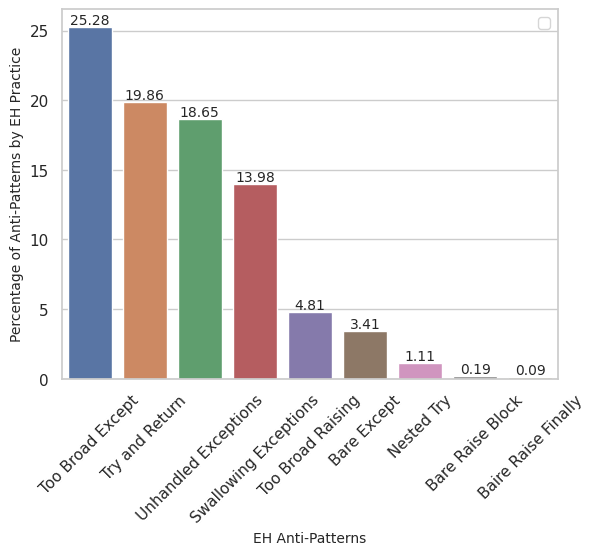

In [129]:
import seaborn as sns
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_total_rq2, x="Exception Handling", y="Percentage")
plt.ylabel("Percentage of Anti-Patterns by EH Practice", fontsize= 10)
plt.xlabel("EH Anti-Patterns", fontsize= 10)
plt.tick_params(axis='x', rotation=45)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=10)

RQs New

In [130]:
df_rq21 = df.groupby('project').agg({'function': ['count'], 'n_captures_misplaced_bare_raise_uni': ['sum'], 'n_generic_except_uni': ['sum'], 'n_captures_broad_raise_uni': ['sum'], 'n_try_pass_uni': ['sum'], 
                                    'n_try_return_uni': ['sum'], 'n_nested_try_uni': ['sum'], 'n_uncaught_exceptions_uni': ['sum'],
                                    'n_try_except_uni' : ['sum'], 'n_raise_uni' : ['sum']}).reset_index()
#df_rq2 = df.agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_try_pass_uni': ['sum'], 'n_generic_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_captures_try_except_raise_uni': ['sum'], 'n_captures_broad_raise_uni': ['sum'], 'n_uncaught_exceptions': ['sum']})
#df_rq2 = df_rq2.max().to_frame().T

In [131]:
#Trys
df_rq21['perc_n_try_pass_uni'] = (df_rq21['n_try_pass_uni']/ df_rq21['n_try_except_uni']) * 100
df_rq21['perc_n_generic_except_uni'] = (df_rq21['n_generic_except_uni']/ df_rq21['n_try_except_uni']) * 100
df_rq21['perc_uncaught_exceptions_uni'] = (df_rq21['n_uncaught_exceptions_uni']/ df_rq21['n_try_except_uni']) * 100
df_rq21['perc_n_try_return_uni'] = (df_rq21['n_try_return_uni']/ df_rq21['n_try_except_uni']) * 100
df_rq21['perc_n_nested_try_uni'] = (df_rq21['n_nested_try_uni']/ df_rq21['n_try_except_uni']) * 100

#Raise
df_rq21['perc_n_captures_misplaced_bare_raise_uni'] = (df_rq21['n_captures_misplaced_bare_raise_uni']/ df_rq21['n_raise_uni']) * 100
df_rq21['perc_n_captures_broad_raise_uni'] = (df_rq21['n_captures_broad_raise_uni']/ df_rq21['n_raise_uni']) * 100

df_rq21

,project,function,n_captures_misplaced_bare_raise_uni,n_generic_except_uni,n_captures_broad_raise_uni,n_try_pass_uni,n_try_return_uni,n_nested_try_uni,n_uncaught_exceptions_uni,n_try_except_uni,n_raise_uni,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_uncaught_exceptions_uni,perc_n_try_return_uni,perc_n_nested_try_uni,perc_n_captures_misplaced_bare_raise_uni,perc_n_captures_broad_raise_uni
,,count,sum,sum,sum,sum,sum,sum,sum,sum,sum,,,,,,,
0,12306,175,0,10,1,3,1,0,0,21,10,14.285714,47.619048,0.000000,4.761905,0.000000,0.000000,10.000000
1,ailearning,924,0,0,0,0,0,0,0,8,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ansible,9734,0,361,138,215,200,33,228,1176,1282,18.282313,30.697279,19.387755,17.006803,2.806122,0.000000,10.764431
3,awesome-python,2,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bert,187,0,0,0,0,0,0,7,0,26,NaN,NaN,inf,NaN,NaN,0.000000,0.000000
5,big-list-of-naughty-strings,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,black,1491,0,9,0,14,13,1,20,66,70,21.212121,13.636364,30.303030,19.696970,1.515152,0.000000,0.000000
7,certbot,4391,0,13,8,25,38,0,15,278,402,8.992806,4.676259,5.395683,13.669065,0.000000,0.000000,1.990050
8,cheat.sh,279,0,0,0,4,0,0,0,13,11,30.769231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [132]:
df_total_rq21 = df_rq21.loc[:, ["project", "function", "perc_n_nested_try_uni", "perc_n_try_pass_uni", "perc_n_generic_except_uni", "perc_uncaught_exceptions_uni", "perc_n_try_return_uni", "perc_n_captures_misplaced_bare_raise_uni", "perc_n_captures_broad_raise_uni"]]
df_total_rq21

,project,function,perc_n_nested_try_uni,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_uncaught_exceptions_uni,perc_n_try_return_uni,perc_n_captures_misplaced_bare_raise_uni,perc_n_captures_broad_raise_uni
,,count,,,,,,,
0,12306,175,0.000000,14.285714,47.619048,0.000000,4.761905,0.000000,10.000000
1,ailearning,924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ansible,9734,2.806122,18.282313,30.697279,19.387755,17.006803,0.000000,10.764431
3,awesome-python,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bert,187,NaN,NaN,NaN,inf,NaN,0.000000,0.000000
5,big-list-of-naughty-strings,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,black,1491,1.515152,21.212121,13.636364,30.303030,19.696970,0.000000,0.000000
7,certbot,4391,0.000000,8.992806,4.676259,5.395683,13.669065,0.000000,1.990050
8,cheat.sh,279,0.000000,30.769231,0.000000,0.000000,0.000000,0.000000,0.000000


In [133]:
#rename columns:
#df_total_rq21.columns = ['Exception Handling', 'Percentage']
#df_total_rq21['Percentage'] = df_total_rq21['Percentage'].round(2)

#order by percentage:
#df_total_rq21 = df_total_rq21.sort_values(by=['Percentage'], ascending=False)
#df_total_rq21

In [134]:
df_total_rq21

,project,function,perc_n_nested_try_uni,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_uncaught_exceptions_uni,perc_n_try_return_uni,perc_n_captures_misplaced_bare_raise_uni,perc_n_captures_broad_raise_uni
,,count,,,,,,,
0,12306,175,0.000000,14.285714,47.619048,0.000000,4.761905,0.000000,10.000000
1,ailearning,924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ansible,9734,2.806122,18.282313,30.697279,19.387755,17.006803,0.000000,10.764431
3,awesome-python,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bert,187,NaN,NaN,NaN,inf,NaN,0.000000,0.000000
5,big-list-of-naughty-strings,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,black,1491,1.515152,21.212121,13.636364,30.303030,19.696970,0.000000,0.000000
7,certbot,4391,0.000000,8.992806,4.676259,5.395683,13.669065,0.000000,1.990050
8,cheat.sh,279,0.000000,30.769231,0.000000,0.000000,0.000000,0.000000,0.000000


In [135]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig = sns.violinplot(x='rule', y='commit', orient= 'v', cut=0, scale='width', data=df_com_adj).get_figure()
plt.ylabel("Number of Commits", fontsize= 10)
plt.xlabel("Exception Handling Smell", fontsize= 10)
plt.tick_params(axis='x', rotation=90)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=10)

NameError: name 'df_com_adj' is not defined